In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pickle

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score
import sklearn
#from SVM.ipynb import plot_confusion_matrix

import itertools

In [2]:
inspire=pd.read_pickle('bigREFSncgrams.pkl')
refs_of_refs=pd.DataFrame(np.loadtxt('reference_coreness.txt')[:,4:],columns=['core_ref_refs','non-core_ref_refs'])
refs_of_refs.head()

,core_ref_refs,non-core_ref_refs
0,0.00000,0.00000
1,0.00000,0.00000
2,0.00000,0.00000
3,0.03392,0.02365
4,0.44114,0.12174


In [3]:
inspire[['core_ref_refs','non-core_ref_refs']]=refs_of_refs[['core_ref_refs','non-core_ref_refs']]
inspire=inspire[['Text','Result','NC score', 'core refs','non-core refs','core_ref_refs','non-core_ref_refs','Category']]
inspire.head()

,Text,Result,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
0,Comparing Robustness of Pairwise and Multiclas...,0,0,0.000000,0.000000,0.00000,0.00000,cs.AI
1,On an Auxiliary Function for Log-Density Estim...,0,0,0.000000,0.000000,0.00000,0.00000,stat.CO
2,The two defaults scenario for stressing credit...,0,0,0.000000,0.000000,0.00000,0.00000,q-fin.RM
3,Coulomb drag as a measure of trigonal warping ...,0,0,0.051282,0.179487,0.03392,0.02365,cond-mat.mes-hall
4,Dissipative Hofstadter Model at the Magic Poin...,2,0,0.647059,0.176471,0.44114,0.12174,hep-th


In [4]:
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples]
inspire_test = inspire[training_samples + validation_samples:]

In [13]:
features=['NC score','core refs','non-core refs','core_ref_refs','non-core_ref_refs']
x_train = inspire_train[features]
y_train = inspire_train['Result']
x_val = inspire_val[features]
y_val = inspire_val['Result']

In [14]:
def plot_confusion_matrix(cm, classes,normalize=False,title='confusion matrix',cmap=plt.cm.Purples):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix")
    print (cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        

In [20]:
def Analyze(classifier,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import classification_report
    clf=classifier.fit(X_train,Y_train)
   # score=clf.score(X_test,Y_test)
    Y_pred=clf.predict(X_test)
    target_names=['CORE','NON-CORE','Rejected']
    target_labels=[2,1,0]
    report=classification_report(Y_test,Y_pred,labels=target_labels,target_names=target_names)
    cm=cm=confusion_matrix(Y_test,Y_pred,labels=[2,1,0],)
    plt.figure()
    plot_confusion_matrix(cm,classes=target_names,normalize=True)
    plt.show()
    print(report)

In [21]:
def modeltesting(X_train, X_validation, Y_train, Y_validation):
    '''Function to test different models and produce a box plot to show the accuracies'''
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import SVC
    scoring = 'accuracy'
    # Spot Check Algorithms
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    #models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    #models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    #models.append(('Naive Bayes', GaussianNB()))
    #models.append(('Neural Network', MLPClassifier()))
    models.append(('LinearSVC', LinearSVC(max_iter=10,class_weight='balanced')))
    models.append(('SGDClassifier', SGDClassifier(max_iter=10,class_weight='balanced',loss='log',penalty='elasticnet')))
    models.append(('SVC', SVC(class_weight='balanced',probability=True,C=0.05,gamma=0.5)))
    
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())    
        print(msg)
        Analyze(model,X_train,Y_train,X_validation,Y_validation)
        
        
        
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    #pyplot.legend()
    plt.ylabel('Accuracy')
    ax.set_xticklabels(names,rotation=13)
    plt.show()

LogisticRegression: 0.921748 (0.039210)
Normalised confusion matrix
[[0.89343803 0.02636007 0.08020191]
 [0.11433757 0.46370236 0.42196007]
 [0.00402037 0.02774055 0.96823908]]


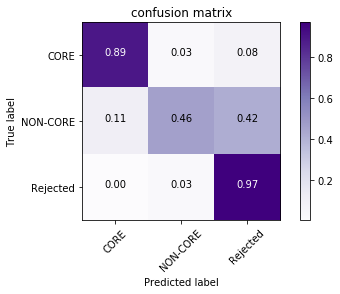

             precision    recall  f1-score   support

       CORE       0.91      0.89      0.90      1783
   NON-CORE       0.67      0.46      0.55      1102
   Rejected       0.92      0.97      0.94      7462

avg / total       0.89      0.90      0.90     10347

KNeighborsClassifier: 0.918011 (0.038685)
Normalised confusion matrix
[[0.89680314 0.04206394 0.06113292]
 [0.10980036 0.47822142 0.41197822]
 [0.00388636 0.03068882 0.96542482]]


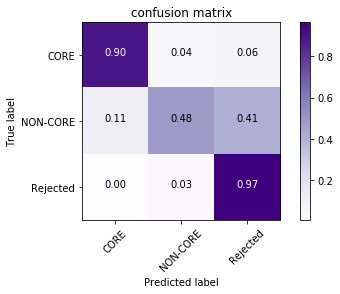

             precision    recall  f1-score   support

       CORE       0.91      0.90      0.91      1783
   NON-CORE       0.63      0.48      0.55      1102
   Rejected       0.93      0.97      0.95      7462

avg / total       0.89      0.90      0.90     10347

LinearSVC: 0.915143 (0.049016)
Normalised confusion matrix
[[0.90297252 0.04206394 0.05496354]
 [0.11433757 0.61524501 0.27041742]
 [0.00536049 0.06539802 0.92924149]]


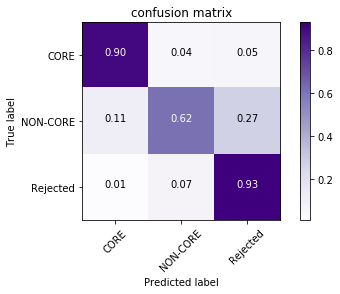

             precision    recall  f1-score   support

       CORE       0.91      0.90      0.90      1783
   NON-CORE       0.55      0.62      0.58      1102
   Rejected       0.95      0.93      0.94      7462

avg / total       0.90      0.89      0.89     10347

SGDClassifier: 0.917399 (0.046812)
Normalised confusion matrix
[[0.89007291 0.04879417 0.06113292]
 [0.08802178 0.66787659 0.24410163]
 [0.00281426 0.07424283 0.92294291]]


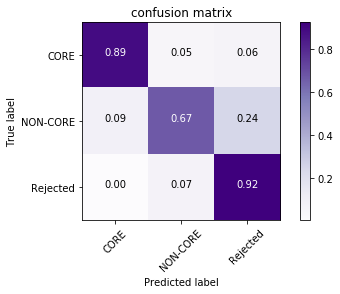

             precision    recall  f1-score   support

       CORE       0.93      0.89      0.91      1783
   NON-CORE       0.53      0.67      0.59      1102
   Rejected       0.95      0.92      0.94      7462

avg / total       0.90      0.89      0.89     10347

SVC: 0.884377 (0.058764)
Normalised confusion matrix
[[0.87436904 0.09478407 0.03084689]
 [0.07350272 0.82123412 0.10526316]
 [0.00187617 0.1467435  0.85138033]]


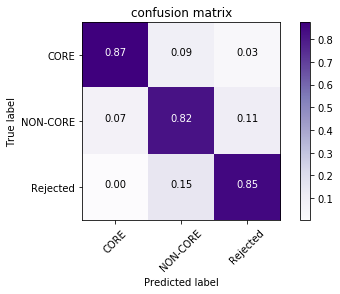

             precision    recall  f1-score   support

       CORE       0.94      0.87      0.91      1783
   NON-CORE       0.42      0.82      0.55      1102
   Rejected       0.97      0.85      0.91      7462

avg / total       0.91      0.85      0.87     10347



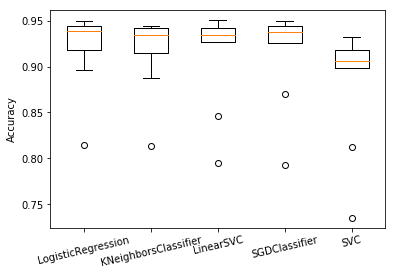

In [22]:
modeltesting(x_train, x_val, y_train, y_val)